In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [2]:
print('torch version:',torch.__version__)

torch version: 2.4.1+cu124


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('device:', device)
else:
    device = torch.device("cpu")
    print('CUDA is not available. Using CPU.')

device: cuda


Solve the single harmonic oscillator ODE:
$$ x_{tt} + \omega^2 \, x = 0$$
with initial conditions
$$x(t=0)=A \sin(\phi) \,, \quad x_t(t=0)=\omega A \cos(\phi)$$  
where
$$\omega\equiv \sqrt{k/m}$$
and the analytical solution is
$$x(t) = A \sin ( \omega t + \phi)$$
with $A$ the oscillation amplitude and $\phi$ the initial phase

The dimension of the harmonic oscillator ODE is [m/s^2] (accelaration). We want to make it dimensionless. If we want to solve the problem in the domain $t \in [0,T]$, we can rescale the variables by $T^2/m$, where $m$ is the mass that oscillates. The rescaled variable is
$$\hat{x}(t) \equiv \frac{T^2}{m}x(t).$$

This is an attempt to address non-dimensionalization of the system. If we also take a different time coordinate $\tau \equiv T \, t$, then when $t \in [0,T]$, $\tau \in [0,1]$. We also have that $\partial_\tau^2 = T^2 \partial_t^2$.

Let's try to evolve $x(\tau)$ (the same $x$), but absorb $T^2$ in the partial derivative and the frequency:
\begin{align}
&
\frac{T^2}{m}\left( x_{tt}(t) + \omega^2 \, x(t) \right) = 0.
\\
\rightarrow
&
\frac{1}{m}\left( x_{\tau \tau} + \hat{\omega}^2 \, x(\tau) \right) = 0,
\end{align}
with $\hat{\omega} \equiv T \omega$. The computational domain is $\tau \in [0,1]$.

Define the neural network:

In [4]:
def RFF(x, sigma2=1.0):
        
    # Random weights and biases for RFF
    B1 = torch.normal(mean = torch.zeros(len(x)).to(device),std=sigma2*torch.ones(1).to(device))
    B2 = torch.normal(mean = torch.zeros(len(x)).to(device),std=sigma2*torch.ones(1).to(device))
     
    x_cos = torch.cos(B1*x)
    x_sin = torch.sin(B2*x)
    RFF_x = torch.cat((x_cos, x_sin)).view(-1,1)
    
    return RFF_x

In [11]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [55]:
#torch.manual_seed(123)

# set the model
# model_1 has arguments (seld, width), but only count from width (tunable)
model = FCN(1,1,32,3).to(device)
#Model()
#model_1(32)
#FCN(1,1,32,3)

# optimizer and initialization of parameters (weights and biases)
optimizer = torch.optim.Adam(model.parameters(),
                              lr=1.e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [56]:
# random (uniform) sample points
def random_domain_points(n):
    t = torch.rand((n,1), requires_grad=True)
    return t

In [57]:
# harmonic oscillator params
m = torch.ones(1).to(device); # mass
k = 5*torch.ones(1).to(device); # spring constant
# freq
omega = torch.sqrt(k/m)

A = 1.0#torch.ones(1); # amplitude
phi = torch.pi*torch.ones(1).to(device) # initial phase
T = 5.0*torch.ones(1).to(device) # tmax
omegahat = (T**2)*omega

In [58]:
n = 50*4 # number of random sampling points

epochs = 20000
gamma1 = 10.0
gamma2 = 10.0

loss_list = []

for epoch in range(int(epochs)):
    #print('epoch = ', epoch, end='\r')
    optimizer.zero_grad() # to make the gradients zero
    #
    #t = random_domain_points(n).to(device)
    #t = RFF(t, sigma2=1.0).to(device)
    t = T*random_domain_points(n).to(device)
    t = T*RFF(t, sigma2=1.0).to(device)
    x = model(t)
    # Derivatives
    x_t = torch.autograd.grad(outputs=x, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(x)
                              )[0]
    x_tt = torch.autograd.grad(outputs=x_t, 
                               inputs=t,
                               create_graph=True,
                               grad_outputs=torch.ones_like(x_t)
                               )[0]
    
    # residual for the bulk of the domain
    #residual = (1/m)*(x_tt + omegahat*x)
    residual = (T**2/m)*(x_tt + omega*x)
    loss_dom = torch.mean(torch.pow(residual,2))
    # residual for initial data
    # sol for x(t=0)
    t0 = torch.zeros(1, requires_grad=True).to(device)
    x0 = model(t0) # solution of x(t=0)
    loss_x0 = torch.mean(torch.pow(x0 - A*torch.sin(phi), 2))
    # sol for x_t(t=0)
    xt0 = torch.autograd.grad(outputs=x0,
                             inputs=t0,
                             create_graph=True,
                             grad_outputs=torch.ones_like(x0)
                             )[0]
    omega = torch.sqrt(k/m)
    loss_xt0 = torch.mean(torch.pow(xt0 - A*omega*torch.cos(phi), 2))
    # LOSS
    loss = loss_dom + gamma1*loss_x0 + gamma2*loss_xt0 + torch.mean(torch.pow(torch.abs(x)-1,2))
    loss_list.append(loss.cpu().detach().numpy())
    # print message
    print('epoch = ', epoch, '| loss = ', loss.item(), '|',  end='\r')
    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 


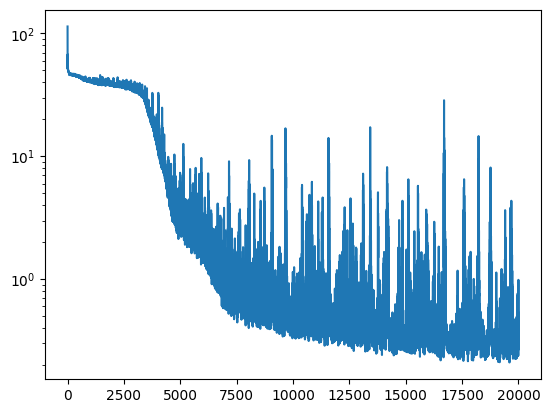

In [49]:
plt.semilogy(loss_list)

In [50]:
# the analytical solution
def analytical_sol(m, k, A, phi, t):
    omega = np.sqrt(k/m)
    x = A*np.sin(omega*t + phi)
    return x

In [52]:
# the time domain; used to visualize the analytical solution
T1 = 5 # tmax
t = torch.linspace(0,T1,100)
# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
tt = torch.linspace(0,T1,100).view(-1,1).to(device)

nn_sol = model(tt).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot


/tmp/ipykernel_3114391/3955138456.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = A*np.sin(omega*t + phi)


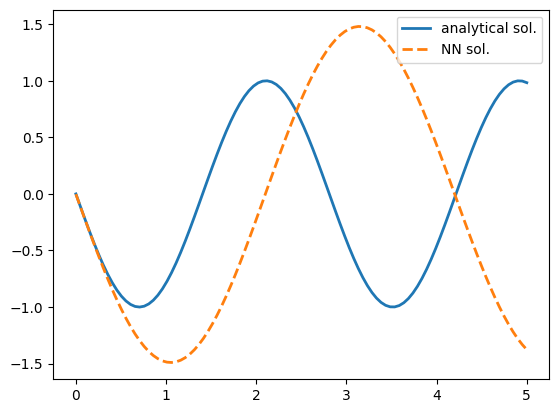

In [53]:
m1 = 1; # mass
k1 = 5; # spring constant
A1 = 1; # amplitude
phi1 = np.pi # initial phase

an_sol = analytical_sol(m1, k1, A1, phi1, t)

plt.figure()
plt.plot(t, an_sol, label="analytical sol.", lw=2)
plt.plot(t, nn_sol, label="NN sol.", lw=2, ls='--')
plt.legend(loc='upper right')
#plt.grid()
#plt.xlim(t[0],t[-1])

In [ ]:
class ODE(torch.nn.Module):
    def __init__(self):
        super(ODE, self).__init__()
        
        self.lam = torch.nn.Parameter(torch.tensor(5.0, requires_grad = True))

        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 40),
            torch.nn.GELU(),
            torch.nn.Linear(40, 40),
            torch.nn.GELU(),
            torch.nn.Linear(40, 1),
        )

        for m in self.net.modules():
            #print(m)
            if isinstance(m, torch.nn.Linear):
                print(m.in_features)
                n = m.weight.size(1)
                print(n)
                torch.nn.init.normal_(m.weight, mean = 0, std = 0.1)
                torch.nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x) * x * (1 - x) 

In [ ]:
ode = ODE()
